## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

## 데이터 저장

In [3]:
# 데이터 로드
train = pd.read_csv('train_eda_code_15.csv')
test = pd.read_csv('test_eda_code_15.csv')

## 모델링

In [4]:
# 데이터 로드
train = pd.read_csv('train_eda_code_15.csv')
test = pd.read_csv('test_eda_code_15.csv')

In [5]:
# ID 열을 제외한 특성과 타겟 변수 분리
X = train.drop(['임신_성공_여부', 'ID'], axis=1)
y = train['임신_성공_여부']

In [6]:
categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "단일_배아_이식_여부",
    "착상_전_유전_검사_사용_여부",
    "착상_전_유전_진단_사용_여부",
    "배아_생성_주요_이유",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "총_생성_배아_수",
    "미세주입된_난자_수",
    "미세주입에서_생성된_배아_수",
    "이식된_배아_수",
    "미세주입_배아_이식_수",
    "저장된_배아_수",
    "미세주입_후_저장된_배아_수",
    "해동된_배아_수",
    "해동_난자_수",
    "수집된_신선_난자_수",
    "저장된_신선_난자_수",
    "혼합된_난자_수",
    "파트너_정자와_혼합된_난자_수",
    "기증자_정자와_혼합된_난자_수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]


In [7]:
# 모든 범주형 변수를 문자열로 변환
X[categorical_columns] = X[categorical_columns].astype(str)
test[categorical_columns] = test[categorical_columns].astype(str)

In [8]:
# OrdinalEncoder를 사용하여 범주형 변수 인코딩
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[categorical_columns] = encoder.fit_transform(X[categorical_columns])
test[categorical_columns] = encoder.transform(test[categorical_columns])

In [9]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 목적 함수 정의
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 2048),
        'max_depth': trial.suggest_int('max_depth', 5, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e2, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-5, 1e1, log=True),
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-03 23:25:09,951] Trial 104 finished with value: 0.7382604133776007 and parameters: {'n_estimators': 2347, 'num_leaves': 50, 'max_depth': 142, 'learning_rate': 0.021188216439538957, 'min_child_samples': 182, 'subsample': 0.7951918621697477, 'colsample_bytree': 0.33700062509197354, 'reg_alpha': 0.10020567478518366, 'reg_lambda': 8.52283471798228e-05, 'min_split_gain': 0.3800055047800433}. Best is trial 104 with value: 0.7382604133776007.


--- Model Performance ---
Model Accuracy: 0.7438218026487741
Model F1 Score: 0.1893593383532897
Model AUC: 0.7382604133776007


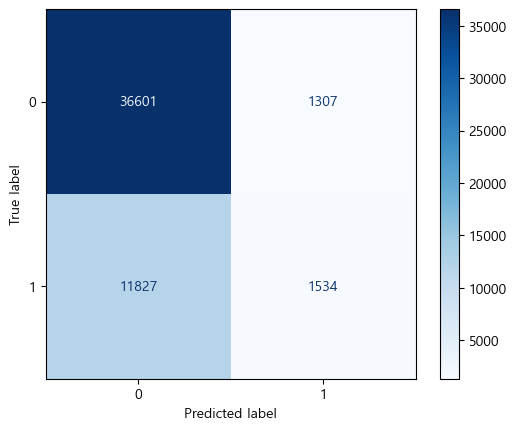

In [13]:
# 모델 초기화
model = lgb.LGBMClassifier(
    n_estimators=2347,
    num_leaves=50,
    max_depth=142,
    learning_rate=0.021188216439538957,
    min_child_samples=182,
    subsample=0.7951918621697477,
    colsample_bytree=0.33700062509197354,
    reg_alpha=0.10020567478518366,
    reg_lambda=8.52283471798228e-05,
    min_split_gain=0.3800055047800433,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [1342]:
# 모델 구축
model = lgb.LGBMClassifier(
    n_estimators=800,
    num_leaves=100,
    max_depth=30,
    learning_rate=0.01,
    random_state=42,
    verbose=-1
)

# 모델 학습 및 예측
model.fit(X, y)
pred_proba = model.predict_proba(test.drop('ID', axis=1))[:, 1]

In [1343]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['probability'] = pred_proba

In [1344]:
sample_submission.to_csv('./total_eda_code15_submit.csv', index=False)

.